# Bibliotecas

In [67]:
# Importando bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, text
import seaborn as sns

# Dados

### Dados

In [68]:
# Definindo os dados
url_itens_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/itens_pedidos.csv'
url_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/pedidos.csv'
url_produto = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/produtos.csv'
url_vendedores = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/vendedores.csv'

In [69]:
# Importando os dados
itens_pedidos = pd.read_csv(url_itens_pedidos)
pedidos = pd.read_csv(url_pedidos)
produtos = pd.read_csv(url_produto)
vendedores = pd.read_csv(url_vendedores)

### Dicionário de dados

**Tabela vendedores**

`nome_vendedor`	Nome do vendedor

`vendedor_id`	Identificador do vendedor

**Tabela itens pedidos**

`estado`	Estado para onde o pedido foi enviado

`frete`	Valor do frete cobrado para o envio do produto

`id_nf`	Identificador da nota fiscal do pedido

`pedido_id`	Identificador do pedido

`produto_id`	Identificador do produto

`quantidade`	Quantidade de pedidos

`valor_total`	Valor total dos pedidos

`valor_unitario`	Valor por unidade do pedido

**Tabela produto**

`condicao`	Condição do produto

`marca`	Marca do produto

`preco`	Preço do produto

`produto`	Nome do produto

`produto_id`	Identificador do produto

`sku`	Identificador do produto no estoque

`Total`	Número total de produtos

**Tabela pedido**

`data_compra`	Data de compra do pedido

`pedido_id`	Identificador do pedido

`produto_id`	Identificador do produto

`total`	Número total de pedidos

`vendedor_id`	Identificador do vendedor

# Alocando tabelas no SQLite

In [70]:
# Criando banco de dados local
engine = create_engine('sqlite:///:memory:')

In [71]:
# Adicionando as tabelas no banco de dados
produtos.to_sql('produtos', engine, index=False)
itens_pedidos.to_sql('itens_pedidos', engine, index=False)
pedidos.to_sql('pedidos', engine, index=False)
vendedores.to_sql('vendedores', engine, index=False)

5

In [72]:
# Inspecionando se todas as tabelas foram adicionadas ao banco de dados
inspector = inspect(engine)
print(inspector.get_table_names())

['itens_pedidos', 'pedidos', 'produtos', 'vendedores']


# Consultas

### Condição dos produtos

In [73]:
# Consulta
query = 'SELECT CONDICAO FROM PRODUTOS'

In [74]:
# Execução da consulta
with engine.connect() as conexao:
    consulta = conexao.execute(text(query))
    dados = consulta.fetchall()
pd.DataFrame(dados, columns=consulta.keys())

,Condicao
0,Usado
1,Usado
2,Usado
3,Usado
4,Usado
...,...
200,Usado
201,Usado
202,Usado
203,Usado


In [75]:
# Criando função para realizar consultas sql
def sql_df(query):
    with engine.connect() as conexao:
        consulta = conexao.execute(text(query))
        dados = consulta.fetchall()
    return pd.DataFrame(dados, columns=consulta.keys())

In [76]:
query = '''
SELECT CONDICAO, COUNT(*) AS 'Quantidade'
FROM PRODUTOS
GROUP BY CONDICAO
ORDER BY Quantidade;
'''
df_produtos = sql_df(query)
df_produtos

,Condicao,Quantidade
0,Novo sem etiqueta,7
1,Novo com etiqueta,22
2,Usado,176


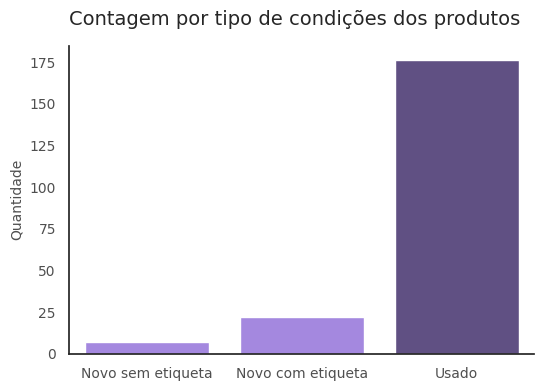

In [77]:
cores = []
max_qtd  = df_produtos['Quantidade'].max()

for qtd in df_produtos['Quantidade']:
    if qtd == max_qtd:
        cores.append('#5D478B')
    else:
        cores.append('#9F79EE')

fig, ax = plt.subplots(figsize=(6,4))
sns.set_theme(style='white')

ax = sns.barplot(data=df_produtos,
                 x='Condicao',
                 y='Quantidade',
                 hue='Condicao',
                 legend=False,
                 palette=cores)
plt.title('Contagem por tipo de condições dos produtos',
          fontsize=14,
          loc='left',
          pad=15)
ax.set_xlabel('')
ax.set_ylabel('Quantidade', color='#4F4F4F', size=10)
ax.xaxis.set_tick_params(labelsize=10, labelcolor='#4F4F4F')
ax.yaxis.set_tick_params(labelsize=10, labelcolor='#4F4F4F')
sns.despine()
plt.show()

### Relacionando tabelas

In [78]:
sql_df('SELECT * FROM PRODUTOS').head(3)

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado


In [79]:
sql_df('SELECT * FROM ITENS_PEDIDOS').head(3)

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0


In [80]:
query = '''
SELECT PRODUTOS.PRODUTO, SUM(ITENS_PEDIDOS.QUANTIDADE) AS quantidade
FROM ITENS_PEDIDOS, PRODUTOS
WHERE ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO
ORDER BY quantidade DESC
LIMIT 10
'''
top_10_vendas = sql_df(query)
top_10_vendas

,produto,quantidade
0,Vestido Recortes Cores,795
1,Calca Jeans Costuras,755
2,Saia Pregas Preta,751
3,Calca Alfaiataria Preta,750
4,Saia Midi Cinto,549
5,Vestido Nude Reta,547
6,Blusa Manga Estampa,536
7,Camisa Xadrez Azul,511
8,Cropped Escritas Pb,508
9,Bomber Tricot Off,507


In [ ]:
cores = ['#5D478B' if x < 4 else '#AB82FF' for x in range(10)]

fig, ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='white')

ax = sns.barplot(data=top_10_vendas,
                 x='quantidade',
                 y='produto',
                 hue='produto',
                 legend=False,
                 palette=cores)
plt.title('Top 10 produtos mais vendidos',
          fontsize=14,
          loc='left',
          pad=15)
ax.set_xlabel('Quantidade vendida', size=10, color='#4F4F4F')
ax.set_ylabel('')
ax.xaxis.set_tick_params(labelsize=10, labelcolor='#4F4F4F')
ax.yaxis.set_tick_params(labelsize=10, labelcolor='#4F4F4F')
sns.despine()
plt.show()

### Análises propostas

Calcular a receita total obtida com a venda de itens.

In [ ]:
sql_df('SELECT * FROM ITENS_PEDIDOS').head(3)

In [ ]:
sql_df('SELECT * FROM PRODUTOS').head(3)

In [ ]:
df_itens_pedidos = sql_df('SELECT VALOR_TOTAL FROM ITENS_PEDIDOS')
receita_total = df_itens_pedidos['valor_total'].sum()
print(f'Receita total das vendas: R$ {receita_total:.2f}')

In [ ]:
# Mesma análise, utilizando função SUM() do SQL
query = '''
SELECT SUM(VALOR_TOTAL) AS Receita
FROM ITENS_PEDIDOS
'''
df_itens_pedidos = sql_df(query)
df_itens_pedidos

Identificar quais as 15 marcas que foram as mais pedidas por quantidades de venda.

In [ ]:
query = '''
SELECT PRODUTOS.MARCA, SUM(ITENS_PEDIDOS.QUANTIDADE) AS quantidade
FROM PRODUTOS, ITENS_PEDIDOS
WHERE PRODUTOS.PRODUTO_ID = ITENS_PEDIDOS.PRODUTO_ID
GROUP BY PRODUTOS.MARCA
ORDER BY Quantidade DESC
LIMIT 15
'''
top_15_marcas = sql_df(query)
top_15_marcas

In [ ]:
cores = ['#5D478B' if x < 3 else '#AB82FF' for x in range(15)]

fig, ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='white')

ax = sns.barplot(data=top_15_marcas,
                 x='quantidade',
                 y='marca',
                 hue='marca',
                 legend=False,
                 palette=cores)
plt.title('Top 15 marcas mais vendidas',
          fontsize=14,
          loc='left',
          pad=15)
ax.set_xlabel('')
ax.xaxis.set_ticks([])
ax.set_ylabel('')
ax.xaxis.set_tick_params(labelsize=10, labelcolor='#4F4F4F')
ax.yaxis.set_tick_params(labelsize=10, labelcolor='#4F4F4F')
sns.despine(bottom=True, left=True)

for i, valor in enumerate(top_15_marcas['quantidade']):
    qtd = f'{valor:,.0f}'.replace(',','.')
    offset = max(top_15_marcas['quantidade']) * 0.02
    ax.text(valor - offset, i, qtd, color='white', fontsize=10, fontweight='bold', ha='right', va='center')

plt.show()

### Filtros

In [ ]:
sql_df('SELECT * FROM PEDIDOS').head(3)

In [ ]:
sql_df('SELECT * FROM PEDIDOS').info()

In [ ]:
# Consulta vendas por vendedor no ano de 2020
query = '''
SELECT VENDEDORES.NOME_VENDEDOR, COUNT(PEDIDOS.PEDIDO_ID) AS 'Quantidade vendas'
FROM VENDEDORES, PEDIDOS
WHERE strftime('%Y', data_compra) = '2020' AND VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY COUNT(PEDIDOS.PEDIDO_ID) DESC;
'''
sql_df(query)

In [ ]:
# Consulta valor médio por vendas de cada vendedor no ano de 2020
query = '''
SELECT VENDEDORES.NOME_VENDEDOR, AVG(PEDIDOS.TOTAL) AS 'Valor médio por vendas'
FROM VENDEDORES, PEDIDOS
WHERE strftime('%Y', data_compra) = '2020' AND VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY AVG(PEDIDOS.TOTAL) DESC;
'''
sql_df(query)

### Análises propostas

Exibir os 10 produtos mais vendidos durante o ano de 2019

In [ ]:
sql_df('SELECT * FROM PEDIDOS').head(3)

In [ ]:
sql_df('SELECT * FROM PRODUTOS').head(3)

In [ ]:
query = '''
SELECT PRODUTOS.PRODUTO, COUNT(PEDIDOS.PEDIDO_ID) AS 'Quantidade vendida'
FROM PRODUTOS, PEDIDOS
WHERE strftime('%Y', data_compra) = '2019' AND PRODUTOS.PRODUTO_ID = PEDIDOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO
ORDER BY COUNT(PEDIDOS.PEDIDO_ID) DESC
LIMIT 10;
'''
mais_vendidos_2019 = sql_df(query)
mais_vendidos_2019

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
sns.set_theme(style='white')

cores = ['#9370DB' if x < 2 else '#B5B5B5' for x in range(10)]

ax = sns.barplot(data=mais_vendidos_2019,
                 x='Quantidade vendida',
                 y='produto',
                 hue='produto',
                 legend=False,
                 palette=cores)
plt.suptitle('Os 10 produtos mais vendidos',
             fontsize=18,
             color='#231F20',
             ha='right',
             x=0.6,
             y=1.07)
plt.title('no ano de 2019',
          fontsize=14,
          loc='right',
          color='#9C9C9C',
          pad=15,
          x=0.25,
          y=1.04)
ax.set_xlabel('')
ax.xaxis.set_ticks([])
ax.set_ylabel('')
ax.xaxis.set_tick_params(labelsize=10, labelcolor='#555655')
ax.yaxis.set_tick_params(labelsize=10, labelcolor='#555655')
sns.despine(bottom=True, left=True)

for i, valor in enumerate(mais_vendidos_2019['Quantidade vendida']):
    qtd = f'{valor:,.0f}'.replace(',','.')
    offset = max(mais_vendidos_2019['Quantidade vendida']) * 0.02
    ax.text(valor - offset, i, qtd, color='white', fontsize=10, fontweight='bold', ha='right', va='center')

ax.text(1.0, 0.64,
        'Os produtos $\\bf{Vestido\\;Recortes\\;Cores}$ e\n'
        '$\\bf{Calca\\;Jeans\\;Costuras}$ foram os que\n'
        'obtiveram maior destaque em\n'
        'quantidade de vendas no ano de $\\bf{2019}$.',
        fontsize=12,
        linespacing=1.5,
        color='#555655',
        bbox=dict(boxstyle="round", fc='#FFFFFF', ec='#555655'),
        transform=ax.transAxes)

plt.show()

Publicar a distribuição através dos meses da receita obtida em vendas no ano de 2020

In [ ]:
sql_df('SELECT * FROM PEDIDOS').head(3)

In [ ]:
sql_df('SELECT * FROM ITENS_PEDIDOS').head(3)

In [ ]:
query = '''
SELECT strftime('%m', data_compra) AS mes, SUM(TOTAL) AS receita
FROM PEDIDOS
WHERE strftime('%Y', data_compra) = '2020'
GROUP BY mes;
'''
receita_2020 = sql_df(query)
receita_2020

In [ ]:
meses = {'01':'Jan', '02':'Fev', '03':'Mar', '04':'Abr', '05':'Mai', '06':'Jun',
         '07':'Jul', '08':'Ago', '09':'Set', '10':'Out', '11':'Nov', '12':'Dez'}

receita_2020['mes'] = receita_2020['mes'].map(meses)
receita_2020

In [ ]:
receita_2020['receita'] = round(receita_2020['receita']/1e6, 2)
receita_2020

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set_theme(style='white')

ax.plot(receita_2020['mes'], receita_2020['receita'], lw=3, color='#BFBEBE',
        marker='o', markersize=8, markerfacecolor='#0077b6', markevery=(2,3))
ax.set_title('Faturamento mensal no ano de 2020',
             fontsize=17, color='#231F20', loc='left')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels([])
ax.xaxis.set_tick_params(labelsize=12, labelcolor='#555655')
ax.set_frame_on(False)

for i in range(2, len(receita_2020['receita']), 3):
    ax.text(x=ax.get_xticks()[i] + 0.2, y=receita_2020['receita'][i],
            s=f'R$ {receita_2020['receita'][i]} milhões', color='#0077b6',
            weight='bold', fontsize=10)

plt.show()

### Relacionamentos

In [ ]:
query = '''
SELECT ESTADO, COUNT(*) AS Pedidos
FROM ITENS_PEDIDOS
GROUP BY ESTADO
ORDER BY Pedidos DESC;
'''
sql_df(query)

In [ ]:
query = '''
SELECT VENDEDORES.NOME_VENDEDOR, COUNT(*) AS quantidade_vendas
FROM PEDIDOS
JOIN VENDEDORES ON VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
JOIN ITENS_PEDIDOS ON ITENS_PEDIDOS.PEDIDO_ID = PEDIDOS.PEDIDO_ID
WHERE ITENS_PEDIDOS.ESTADO = 'BR-SP'
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY quantidade_vendas DESC;
'''
sql_df(query)

### Análises propostas

Listar as marcas vendidas em São Paulo por quantidade de pedidos, que podem ser representadas em uma tabela

In [ ]:
query = '''
SELECT PRODUTOS.MARCA, COUNT(*) AS quantidade_vendida
FROM PRODUTOS
JOIN ITENS_PEDIDOS ON ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
WHERE ITENS_PEDIDOS.ESTADO = 'BR-SP'
GROUP BY PRODUTOS.MARCA
ORDER BY quantidade_vendida DESC;
'''
marcas_sp = sql_df(query)
marcas_sp

Publicar os produtos que são mais vendidos na época de Natal no Brasil todo

In [ ]:
query = '''
SELECT PRODUTOS.PRODUTO, COUNT(*) AS quantidade_vendida
FROM ITENS_PEDIDOS
JOIN PRODUTOS ON PRODUTOS.PRODUTO_ID = ITENS_PEDIDOS.PRODUTO_ID
JOIN PEDIDOS ON PEDIDOS.PEDIDO_ID = ITENS_PEDIDOS.PEDIDO_ID
WHERE strftime('%m', PEDIDOS.data_compra) = '12'
GROUP BY PRODUTOS.PRODUTO
ORDER BY quantidade_vendida DESC;
'''
produtos_dez = sql_df(query)
produtos_dez